In [22]:
import csv
import datetime
import glob
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.signal import medfilt
from scipy.signal import find_peaks
from scipy.signal import correlate

In [23]:
# specify the data to be analyzed 
main_path = r"C:\Users\knut\Nextcloud\Geotechnik-Freigaben\Dienstleistung\Versuche_FuE\F_05_Schüttkegel_Anton\Versuche"
psd = r"SP-4-D"
subset = 3
trial = 2

**definitions**

In [24]:
def get_valid_daty_with_IQR(data_with_outlier):
    # Berechne die Quartile
    q1 = np.quantile(data_with_outlier, 0.25, axis=0)
    q3 = np.quantile(data_with_outlier, 0.75, axis=0)
    
    # Berechne den Interquartilsabstand
    iqr_local = q3 - q1
    
    # Definiere die Grenzen zur Identifikation von Ausreißern
    lower_bound = q1 - 1.5 * iqr_local
    upper_bound = q3 + 1.5 * iqr_local
    
    # Identifiziere Ausreißer
    outliers = (data_with_outlier < lower_bound) | (data_with_outlier > upper_bound)
    
    # Bestimme gültige Daten, die keine Ausreißer sind
    valid_mask = ~outliers
    
    return valid_mask

def calculate_std_moving_window(data, window_size, minimum_offset):
    n = data.shape[1]  # Annahme: zweite Dimension ist die relevante
    std_ind = np.zeros(n,dtype=int)
    # Schleifen über die Daten für die Berechnung der gleitenden Standardabweichung
    for i in range(n - window_size + 1):
        # Extrahiere das aktuelle Fenster
        data_selected = data[:, i:i + window_size]
        ind_max = np.argmax(data_selected, axis=0)
        # Berechne die Standardabweichung der maximalen Werte
        std = int(np.round(np.std(ind_max, ddof=0)))  # ddof=0 für Population Standardabweichung
        # Setze das Offset basierend auf dem berechneten Standardabweichung
        if std < minimum_offset:
            std_ind[i] = minimum_offset
        else:
            std_ind[i] = std
    # Fülle die verbleibenden Werte mit dem Mittelwert der berechneten Offsets
    std_ind[n-window_size+1:] = np.mean(std_ind[n-2*window_size+1:n-window_size+1])

    return std_ind.astype(int)

def calculate_ind_moving_window(data, window_size):
    n = data.shape[1]  # Annahme: zweite Dimension ist die relevante
    ind_out = np.zeros(n,dtype=int)
    # Schleifen über die Daten für die Berechnung der gleitenden Standardabweichung
    for i in range(n - window_size + 1):
        # Extrahiere das aktuelle Fenster
        data_selected = data[:, i:i + window_size]
        ind_max = np.argmax(data_selected, axis=0)
        # Berechne die Standardabweichung der maximalen Werte
        ind_mean = int(np.round(np.mean(ind_max)))  # ddof=0 für Population Standardabweichung
        # Setze das Offset basierend auf dem berechneten Standardabweichung
        ind_out[i] = ind_mean
    # Fülle die verbleibenden Werte mit dem Mittelwert der berechneten Offsets
    ind_out[n-window_size+1:] = np.mean(ind_out[n-2*window_size+1:n-window_size+1])

    return ind_out.astype(int)

**Preprocess the data**

*load data*

In [25]:
# Issues:
# Calculation of the rotation angle derived from binary_angle_code not working, 12bit (4096 Values) ???

folder = os.path.join(main_path, psd, f"{psd}-{subset}", str(trial))
z_files = glob.glob(os.path.join(folder, "*_Z_*.npy"))
lumi_files = glob.glob(os.path.join(folder, "*_LUMI_*.npy"))
Info_files = glob.glob(os.path.join(folder, "*_Info_*"))

if z_files:
    z_data = np.load(z_files[0])
    z_data = z_data.astype(float)
else:
    print("No Z file found.")

if lumi_files:
    lumi_data = np.load(lumi_files[0])
    lumi_data = lumi_data.astype(float)
else:
    print("No LUMI file found.")

if Info_files:
    with open(Info_files[0], 'r', encoding='utf-8') as file:
        lines = file.readlines()
for line in lines:
    line = line.strip()
    match = re.findall(r"\d+,\d+", line)
    if match:
        number_str = match[0].replace(',', '.')
        dry_mass = float(number_str)

SCALE_Z = 0.004013243704223939 #derived by kalibrierung.ipynb 
SCALE_X = 0.050225457194533765 #derived by kalibrierung.ipynb
GRADIENT_TILT = -0.1590503214142255 #derived by kalibrierung.ipynb | to correct the tilt of the laser

**Preprocess Data**

*vanish outliers in z-Data & Median filter the data*

In [26]:
KERNELSIZE_LUMI = 5
KERNELSIZE_Z = 3

# generates a mask 
valid = get_valid_daty_with_IQR(z_data)
# truncate data which exceed 13000 values
if z_data.shape[1] > 13000:
    z_data = z_data[:,:13000]
if lumi_data.shape[1] > 13000:
    lumi_data = lumi_data[:,:13000]
# Convert to object scale
# filter lumi data by moving median in 2D
lumi_data_f = np.zeros(np.shape(lumi_data))
for i in range(lumi_data_f.shape[0]):
    lumi_data_f[i,:-1] = medfilt(lumi_data[i,:-1],KERNELSIZE_LUMI)
for j in range(lumi_data.shape[1]):
    lumi_data_f[:-1,j] = medfilt(lumi_data_f[:-1,j],KERNELSIZE_LUMI)
#
#
# filter z-data by moving median in 2D
z_data_f = np.copy(z_data)
for i in range(z_data_f.shape[0]):
    to_filter = z_data[valid[:,i],i]
    z_data_f[valid[:,i],i] = medfilt(to_filter,KERNELSIZE_Z)


# truncate last column to avoid edge effects of the median filter
z_data_f = z_data_f[:,:-1]
lumi_data_f = lumi_data_f[:,:-1]
x_data_f = np.linspace(0,len(z_data_f),len(z_data_f))
x_data = np.linspace(0,len(z_data),len(z_data))

*find rotation center*

*Calculationg a linear regression on each side of the cone and utilze the intersection point*

In [27]:
OUTERCENTEROFFSET = 300 # offset from the center to start the search for the outer edge
WINDOWSIZE = 20
MINIMUMOFFSET = 10
x_int = np.zeros(np.shape(z_data_f)[1])
# Anzahl der Werte im Array
first_valid = np.zeros(np.shape(z_data_f)[1],dtype=int)
first_valid = np.argmax(valid,axis=0)
# the lower distance to the index of the maximum is the standard deviation within the WINDOWSIZ
# but at least MINIMUMOFFSET 
inner_center_offset = calculate_std_moving_window(z_data_f,WINDOWSIZE,MINIMUMOFFSET)
# the index of the maximum is calculated with a median filter 
index_max_z = calculate_ind_moving_window(z_data_f,WINDOWSIZE)
for i in range(np.shape(z_data_f)[1]):
    # adaptiv calculation of the index used for the linear interpolation 
    # define left and right fit ranges
    left_start = max(first_valid[i], int(index_max_z[i]-OUTERCENTEROFFSET))
    left_stop = max(first_valid[i]+MINIMUMOFFSET, int(index_max_z[i]-inner_center_offset[i]))
    right_start = min(index_max_z[i]+MINIMUMOFFSET, int(index_max_z[i]+inner_center_offset[i]))
    right_stop = min(z_data_f.shape[0], int(index_max_z[i]+OUTERCENTEROFFSET))
    # define row ranges for left and right linear fits
    row_range_left = slice(left_start, left_stop)
    row_range_right = slice(right_start, right_stop)
    # define a mask to omit nan within the interpolation
    mask_left = valid[left_start:left_stop,i]
    mask_right = valid[right_start:right_stop,i]
    # linear fit left and right of the peak
    x_data_extracted_left = x_data[row_range_left][mask_left]
    z_data_extracted_left = z_data_f[row_range_left,i][mask_left]
    x_data_extracted_right = x_data[row_range_right][mask_right]
    z_data_extracted_right = z_data_f[row_range_right,i][mask_right]
    # calculate a linear interpolation left and right 
    m_left, b_left = np.polyfit(x_data_extracted_left, z_data_extracted_left, 1)
    m_right, b_right = np.polyfit(x_data_extracted_right, z_data_extracted_right, 1)
    x_int[i] = round((b_right - b_left) / (m_left - m_right))

x_int_valid = get_valid_daty_with_IQR(x_int)
x_int[~x_int_valid] = round(np.mean(x_int[x_int_valid]))
x_int = x_int.astype(int)
print(f"Median of intersection points: {np.median(x_int*SCALE_X):.1f} mm +- {np.std(x_int*SCALE_X):.1f} mm")

Median of intersection points: 16.0 mm +- 2.4 mm


**correlate the signal to find repeated scans**

In [28]:
OFFSET = 300 # Scans skiped at the beginning to avoid edge effects
LASTINDEX = 4000 # last scans, the repeat should be found in

y = x_int.astype(float)
y1 = (y-np.mean(y[:-1]))/np.std(y[:-1])
y2 = (y-np.mean(y[:-1]))/np.std(y[:-1])
autocorr = correlate(y1,y2, mode='full')
lags = np.arange(-len(y1)+1, len(y1))

# Only look at positive lags (right half)
autocorr_pos = autocorr[len(y1)-1:]
lags_pos = lags[len(y1)-1:]
# Find the first peak after lag 0
peaks = np.nan
peaks = np.argmax(autocorr_pos[-LASTINDEX:])
if not np.isnan(peaks):
    repeat_index = lags_pos[peaks]  # first peak after lag 0
    lstart = 0+OFFSET
    lend = len(x_int)-LASTINDEX+repeat_index+OFFSET
    print(f"Signal repeats at index:, {repeat_index} the data is truncated to {lend-lstart} scans")
    #truncate 2D-arrays
    x_temp = np.linspace(0,len(x_int),len(x_int))
    lumi_data_t = lumi_data[:,lstart:lend]
    lumi_data_f_t = lumi_data_f[:,lstart:lend]
    z_data_t = z_data[:,lstart:lend]
    z_data_f_t = z_data_f[:,lstart:lend]
    valid_t = valid[:,lstart:lend]
    x_int_t = x_int[lstart:lend]
else:
    print("No repeat found.")

Signal repeats at index:, 1402 the data is truncated to 8901 scans


**Rotate, shift, truncate and scale z-Data and lumi data** <br>
*Rotate and shift in x direction*

In [29]:
SAMPLESIZE = 2500 # number of samples in x direction for the final data set
x_data_f_r_s = np.linspace(0,SAMPLESIZE,SAMPLESIZE)

# rotate data
diff = GRADIENT_TILT*z_data_f_t.shape[0]
rot_y = np.linspace(0, diff, z_data_f_t.shape[0])
z_data_f_t_r = z_data_f_t - rot_y[:, None]

#x-Shift and trunc data in x direction
z_data_f_r_t_sx = np.zeros((SAMPLESIZE,np.shape(z_data_f_t_r)[1]))    
lumi_data_f_sx = np.zeros((SAMPLESIZE,np.shape(lumi_data_f)[1]))
valid_t_s = np.zeros((SAMPLESIZE,np.shape(valid_t)[1]),dtype=bool)

for i in range(np.shape(z_data_f_t_r)[1]):
    local_valid = valid_t[x_int_t[i]:x_int_t[i]+SAMPLESIZE,i]
    valid_t_s[:,i] = np.astype(local_valid,np.bool)
    z_data_f_r_t_sx[:,i] = z_data_f_t_r[x_int_t[i]:x_int_t[i]+SAMPLESIZE,i]
    lumi_data_f_sx[:,i] = lumi_data_f[x_int_t[i]:x_int_t[i]+SAMPLESIZE,i]

*Find the intersection of the slope with the plate*

In [30]:
RIGHTSTART = 1500 #left edge for the calculation of the level of the plate
RIGHTSTOP = 2500 #right edge for the calculation of the level of the plate
MAXTHRESHOLD = 1.05 #Threshold to find a value biger then the maximum of the plate
LEFTOFFSET = 500 #Samples used to calculate the linear interpolation along the slope
x_int_floor = np.zeros(np.shape(z_data_f_r_t_sx)[1])
z_data_f_r_t_sx_sz = np.zeros((SAMPLESIZE,np.shape(z_data_f_r_t_sx)[1]))
b_right = np.zeros(x_int_floor.shape)
for i in range(np.shape(z_data_f_t)[1]):
    # define left and right fit ranges
    # define row ranges for left and right linear fits
    right_stop = min(z_data_f_r_t_sx.shape[0], RIGHTSTOP)
    row_range_right = slice(RIGHTSTART, right_stop)
    # linear fit left and right of the peak
    b_right[i] = np.min(z_data_f_r_t_sx[row_range_right,i])
    b_right_ind = np.argmin(z_data_f_r_t_sx[row_range_right,i])+RIGHTSTART
    #adaptive calculate the row range left
    #max_right = np.max(z_data_f_r_t_sx[row_range_right,i])
    left_stop = np.where(z_data_f_r_t_sx[:b_right_ind,i] > MAXTHRESHOLD*b_right[i])[0][-1]
    left_start = left_stop - LEFTOFFSET
    row_range_left = slice(left_start, left_stop)
    m_left, b_left = np.polyfit(x_data_f_r_s[row_range_left], z_data_f_r_t_sx[row_range_left,i], 1)
    x_int_floor[i] = (b_right[i] - b_left) / (m_left)
print(f"Median of radius: {np.median(x_int_floor*SCALE_X):.1f} mm +- {np.std(x_int_floor*SCALE_X):.1f} mm")
x_int_floor = x_int_floor.astype(int)

# z-Shift by floor intersection 
# 2025/09/10 changed. Minimum value calculated with b_right is now used for the calculation of the z-Shift
for i in range(np.shape(z_data_f_r_t_sx)[1]):
    z_data_f_r_t_sx_sz[:,i] = z_data_f_r_t_sx[:,i]-b_right[i]

Median of radius: 85.4 mm +- 3.3 mm


*convert to object scale*

In [31]:
# Convert to object scale
z_data_f_r_t_sx_sz_obj = z_data_f_r_t_sx_sz*SCALE_Z
x_data_f_r_t_s_obj = np.linspace(0,SCALE_X*len(z_data_f_r_t_sx_sz),len(z_data_f_r_t_sx_sz))

**Calculate the angle of rotation with the binary code** (not executed)

In [32]:
# Issue, transformation of the 12 bit binary works, results are not plausible

# LUMISTART = 1910 # start index of the estimation of the binary mask
# LUMIOFFSET = 25  # offset to the start index
# LUMISTEP = 50 # step width of the binary mask

# lumi_mask = np.zeros(np.shape(lumi_data_f_s))
# for j in range(lumi_data_f_s.shape[1]):
#     lumi_max = np.max(lumi_data_f_s[2200:-1,j])
#     lumi_mean = np.mean(lumi_data_f_s[2200:-1,j])
#     lumi_mask[:-1,j] = np.where((lumi_data_f_s[:-1,j] >= 600), 1, 0)

# binary_angle_code = np.zeros((12,np.shape(lumi_data_f_s)[1]))
# for i in range(lumi_mask.shape[1]):
#     for j in range(binary_angle_code.shape[0]):
#         # sum all elements within the window to check for a binary 1
#         lumi_mask_binary_sum = np.sum(lumi_mask[LUMISTART+LUMIOFFSET+(j-1)*LUMISTEP:LUMISTART+LUMIOFFSET+j*LUMISTEP,i])
#         if lumi_mask_binary_sum >= 0.7*LUMISTEP:
#             binary_angle_code[j,i] = 1

# rotation_angle = np.zeros((np.shape(binary_angle_code)[1]))
# for i in range(np.shape(rotation_angle)[0]):
#     rotation_angle[i] = binary_array_to_decimal(binary_angle_code[:,i])
# plt.plot(rotation_angle)
# plt.show()

**Calculate Cone Volume**

*Procedure 1: mean radius and mean height* <br>
$V_{c,geo} = \frac{1}{3} \pi \bar{r}^2 \bar{h}$ <br>

In [33]:
r_mean = np.mean(x_int_floor.astype(float)*SCALE_X)
h_mean = np.mean(z_data_f_r_t_sx_sz_obj[0,:][valid_t_s[0,:]])
v_cone_geometrical = (1/3)*np.pi*r_mean*r_mean*h_mean
#print(f"Geometrisches Volumen des Kegels: {v_cone_geometrical/1000:.1f} cm³")

*Procedure 2: derived by the mean area* <br>
$V_{c,area} = \bar{A} \frac{2}{3} \pi \bar{r}$ <br>
with: <br>
$\bar{A} = \frac{1}{N}\sum_{1}^{N} A_i$ <br>
and: <br>
$A_i = \frac{z_{i-1}+z_i}{2}\left(x_{i-1}-x_i\right)$ (numerical integration using the trapeziodal rule)

In [34]:
area_local = np.zeros(np.shape(z_data_f_r_t_sx_sz_obj)[1])
for i in range(np.shape(z_data_f_r_t_sx_sz_obj)[1]):
    mask_valid = valid_t_s[0:x_int_floor[i],i]
    z_data_valid = z_data_f_r_t_sx_sz_obj[0:x_int_floor[i],i][mask_valid]
    x_data_valid = x_data_f_r_t_s_obj[0:x_int_floor[i]][mask_valid]
    area_local[i] = integrate.trapezoid(z_data_valid, x_data_valid)
area_mean = np.mean(area_local)
v_cone_area = area_mean*(2/3)*np.pi*r_mean
#print(f"Volumen des Kegels über Flächenintegration mit mittleren Radius: {v_cone_area/1000:.1f} cm³")

*Procedure 3: integrating the cone area picewise*

In [35]:
h_map = np.linspace(0,np.max(z_data_f_r_t_sx_sz_obj),100)
poloar_coordinate = np.linspace(0,2*np.pi,np.shape(z_data_f_r_t_sx_sz_obj)[1])
diff_h_map = np.diff(h_map)[0]
diff_polar_coordinate = np.diff(poloar_coordinate)[0]
d_area = np.zeros(np.shape(z_data_f_r_t_sx_sz_obj)[1]-1)
d_v_cone_numeric = np.zeros(len(area_local))

v_cone_numeric = 0.0
for i in range(len(area_local)):
    ri = x_data_f_r_t_s_obj[x_int_floor[i]]
    v_cone_numeric += area_local[i] *diff_polar_coordinate*ri*(1/3)

#print(f"Volumen des Kegels über numerische Integration mit diskretem Radius: {v_cone_numeric/1000:.1f} cm³")


**Calculate the angle of repose**

In [36]:
def calculate_slope_angle(x, z,x_edge_left,x_edge_right,valid_mask, x_edge_offset,ANGLESINPROFILE=1):
    # x ... x-coordinates of the slope (n,1)
    # z ... z-coordinates of the slope (n,m)
    # x_edge_left ... left edge of the slope (n,1)
    # x_edge_right ... right edge of the slope (n,1)   
    # ANGLESINPROFILE ... number of angles calculated along each slope
    angle = np.zeros((np.shape(z)[1],ANGLESINPROFILE))
    ind_start = np.zeros((np.shape(z)[1],ANGLESINPROFILE), dtype=int)
    ind_stop = np.zeros((np.shape(z)[1],ANGLESINPROFILE), dtype=int)
    for i in range(np.shape(z)[1]):
        ind_length = int(x_edge_right[i]-x_edge_left[i]-2*x_edge_offset)
        ind_step = int(ind_length/ANGLESINPROFILE)
        for j in range(ANGLESINPROFILE):
            ind_start[i,j] = int(x_edge_left[i]+x_edge_offset+(j)*ind_step)
            ind_stop[i,j] = int(ind_start[i,j]+ind_step)
            x_range = slice(ind_start[i,j], ind_stop[i,j])
            valid_ind = valid_mask[x_range,i] 
            x_valid = x[x_range][valid_ind]
            z_valid = z[x_range,j][valid_ind]
            m, _ = np.polyfit(x_valid, z_valid, 1)
            angle[i,j] = (-1)*np.degrees(np.arctan(m))
    return angle, ind_start, ind_stop

ANGLESINPROFILE = 1 # angles calculate along each slope

angle_local, ind_global_slope_start, ind_global_slope_end = calculate_slope_angle(
                x_data_f_r_t_s_obj, 
                z_data_f_r_t_sx_sz_obj,
                np.zeros(x_int_floor.shape), 
                x_int_floor,
                valid_t_s,
                100,
                ANGLESINPROFILE)
mean_angle = np.mean(angle_local)
std_angle = np.std(angle_local)

# calculate aditionaly several angles of repose along each slope
angle_local, ind_local_slope_start, ind_local_slope_end = calculate_slope_angle(
                x_data_f_r_t_s_obj, 
                z_data_f_r_t_sx_sz_obj,
                np.zeros(x_int_floor.shape), 
                x_int_floor,
                valid_t_s,
                100,
                5)
#print(f"Mittlerer Neigungswinkel des Kegels: {mean_angle:.2f}° ± {std_angle:.2f}°")

In [37]:
# Sample list of lines as an example
res_file_filename = f"{subset}_{str(trial)}_RES_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.csv"
res_file = os.path.join(folder,res_file_filename)
data = [ 
    ['dry mass' , 'md', dry_mass, 'g'],
    ['number of scans', 'n_scans', np.shape(z_data_f_r_t_sx_sz_obj)[1], ''],
    ['stadard deviation of x-Positon of cone center', 'std_x_int', np.std(x_int*SCALE_X), 'mm'],
    ['standard deviation of x-Positon of floor intersection', 'std_x_int_floor', np.std(x_int_floor*SCALE_X), 'mm'],
    ['mean radius of the cone', 'r_mean', r_mean, 'mm'],
    ['mean height of the cone', 'h_mean', h_mean, 'mm'],
    ['volume of the cone calculated by geometry', 'v_cone_geometrical', v_cone_geometrical, 'mm3'],
    ['volume of the cone calculated by area integration', 'v_cone_area', v_cone_area, 'mm3'],
    ['volume of the cone calculated by numeric integration', 'v_cone_numeric', v_cone_numeric, 'mm3'],
    ['mean slope angle of the cone', 'mean_angle', mean_angle, 'deg'],
    ['standard deviation of the slope angle of the cone', 'std_angle', std_angle, 'deg'],
    ['x-Position of the start of the slope', 'x_slope_start', np.median(x_data_f_r_t_s_obj[ind_global_slope_start]), 'mm'],
    ['x-Position of the end of the slope', 'x_slope_end', np.median(z_data_f_r_t_sx_sz_obj[ind_global_slope_end]), 'mm']
]
for i in range(angle_local.shape[1]):
    data.append([f'slope angle {i+1}', f'angle_{i+1}', np.mean(angle_local[:,i]), 'deg'])
    data.append([f'x-Position of the start of the slope angle {i+1}', f'x_local_slope_start_{i+1}', np.median(x_data_f_r_t_s_obj[ind_local_slope_start[:,i]]), 'mm'])
    data.append([f'x-Position of the end of the slope angle {i+1}', f'x_local_slope_end_{i+1}', np.median(x_data_f_r_t_s_obj[ind_local_slope_end[:,i]]), 'mm'])
# Open or create a CSV file in write mode
with open(res_file, 'w', newline='') as csvfile: # Create a CSV writer object
    csvwriter = csv.writer(csvfile)
    # Write the header row
    csvwriter.writerow(['Description','Parameter', 'Value', 'Unit'])
    csvwriter.writerows(data)
print("CSV file 'results.csv' has been created successfully.")

CSV file 'results.csv' has been created successfully.


*Summarized results*

file evaluated:   SP-4-D-3 trial: 2
number of scans n_scans 8901
Median of tip intersection points: 16.0 mm +- 2.4 mm
Median of radius: 85.4 mm +- 3.3 mm
---------------
volume of the cone calculated by geometry: 471.9 cm³
volume of the cone calculated by num. integration with mean radius: 506.4 cm³
volume of the cone calculated by num. integration with distinct radius: 507.5 cm³
---------------
Mean angle of repose: 35.46° ± 0.16°


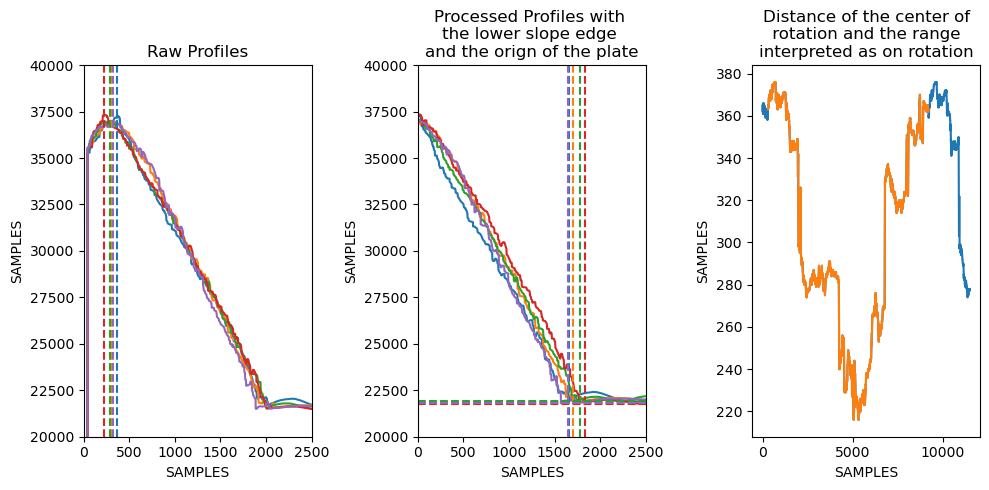

In [38]:
STARTIND = 1
ENDIND = z_data_f_r_t_sx_sz_obj.shape[1]
PROFILES = 5
stepsize = int((ENDIND-STARTIND)/PROFILES)
print(f"file evaluated:   {psd}-{subset} trial: {str(trial)}")
print('number of scans', 'n_scans', np.shape(z_data_f_r_t_sx_sz_obj)[1])
print(f"Median of tip intersection points: {np.median(x_int*SCALE_X):.1f} mm +- {np.std(x_int*SCALE_X):.1f} mm")
print(f"Median of radius: {np.median(x_int_floor*SCALE_X):.1f} mm +- {np.std(x_int_floor*SCALE_X):.1f} mm")
print('---------------')
print(f'volume of the cone calculated by geometry: {v_cone_geometrical/1000:.1f} cm³')
print(f'volume of the cone calculated by num. integration with mean radius: {v_cone_area/1000:.1f} cm³')
print(f'volume of the cone calculated by num. integration with distinct radius: {v_cone_numeric/1000:.1f} cm³')
print('---------------')
print(f"Mean angle of repose: {mean_angle:.2f}° ± {std_angle:.2f}°")
# plot for verification
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
z_plot_raw = axes[0].plot(z_data_f[:,lstart+STARTIND:lstart+ENDIND:stepsize])
i=0
for x in x_int_t[STARTIND:ENDIND:stepsize]:
    axes[0].axvline(x,color=z_plot_raw[i].get_color(),linestyle="--")
    i=i+1
axes[0].set_ylim([20000,40000])
axes[0].set_xlim([0,SAMPLESIZE])
axes[0].set_xlabel("SAMPLES")
axes[0].set_ylabel("SAMPLES")
axes[0].set_title("Raw Profiles")
z_plot = axes[1].plot(z_data_f_r_t_sx[:,STARTIND:ENDIND:stepsize])
i=0
for x in x_int_floor[STARTIND:ENDIND:stepsize]:
    axes[1].axvline(x,color=z_plot[i].get_color(),linestyle="--")
    i=i+1
i=0
for y in b_right[STARTIND:ENDIND:stepsize]:
    axes[1].axhline(y,color=z_plot[i].get_color(),linestyle="--")
    i=i+1
axes[1].set_xlabel("SAMPLES")
axes[1].set_ylabel("SAMPLES")
axes[1].set_title("Processed Profiles with \nthe lower slope edge \nand the orign of the plate")
axes[1].set_ylim([20000,40000])
axes[1].set_xlim([0,SAMPLESIZE])
#....
axes[2].plot(x_temp, x_int)
axes[2].plot(x_temp[lstart:lend], x_int_t)
axes[2].set_xlabel("SAMPLES")
axes[2].set_ylabel("SAMPLES")
axes[2].set_title("Distance of the center of\n rotation and the range \ninterpreted as on rotation")
plt.tight_layout()
plt.show()


In [39]:
import math as m
x_cord = np.zeros(np.shape(z_data_f_r_t_sx_sz_obj))
y_cord = np.zeros(np.shape(z_data_f_r_t_sx_sz_obj))
for i in range(np.shape(z_data_f_r_t_sx_sz_obj)[1]):
    ri = x_data_f_r_t_s_obj
    theta = poloar_coordinate[i]
    x_cord[:,i] = ri*m.cos(theta)
    y_cord[:,i] = ri*m.cos(theta)



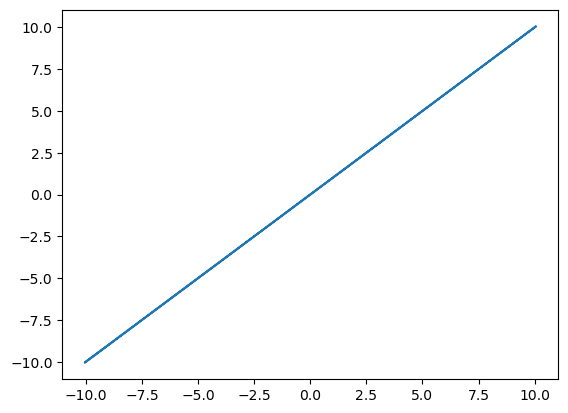

In [40]:
plt.plot(x_cord[200,:-1:100],y_cord[200,:-1:100])
plt.show()